In [81]:
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"

class BM25Retriever:
    def __init__(self, book_texts):
        self.tokenizer = word_tokenize
        self.tokenized_corpus = [self.tokenizer(doc) for doc in book_texts]
        self.bm25 = BM25Okapi(self.tokenized_corpus)
        self.book_texts = book_texts

    def retrieve_passages(self, claims, top_k=5):
        batched_passages = []
        for claim in claims:
            tokenized_claim = self.tokenizer(claim)
            doc_scores = self.bm25.get_scores(tokenized_claim)
            top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:top_k]
            passages = [self.book_texts[idx] for idx in top_k_indices]
            batched_passages.append(passages)
        return batched_passages

In [82]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import faiss

class DPRRetriever:
    def __init__(self, book_texts):
        self.context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
        self.context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(device)
        self.question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
        self.question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)

        self.book_texts = book_texts
        self.context_embeddings = self.encode_contexts(book_texts)

    def encode_contexts(self, texts):
        context_embeddings = []
        for text in tqdm(texts, desc="Encoding Contexts"):
            context_input = self.context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            context_embedding = self.context_encoder(**context_input).pooler_output
            context_embeddings.append(context_embedding.cpu().detach().numpy())
        context_embeddings = torch.tensor(context_embeddings).squeeze(1)
        return context_embeddings

    def retrieve_passages(self, claims, top_k=5):
        batched_passages = []
        for claim in tqdm(claims, desc="Retrieving Passages"):
            claim_input = self.question_tokenizer(claim, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            claim_embedding = self.question_encoder(**claim_input).pooler_output

            # Using FAISS for similarity search
            index = faiss.IndexFlatIP(claim_embedding.size(1))
            index.add(self.context_embeddings.cpu().detach().numpy())
            _, indices = index.search(claim_embedding.cpu().detach().numpy(), top_k)

            passages = [self.book_texts[idx] for idx in indices[0]]
            batched_passages.append(passages)
        return batched_passages

In [83]:
# Load the CSV data
claims, entailments = [], []
with open('data scraping/evaluation_entailment.csv', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        claims.append(row['summary_sentence'])
        entailments.append(row['Entailment'])

book_texts = []
with open('data scraping/extracted_data.csv', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["model_size"] == '175b':
            book_texts.append(row["book_text"])


In [84]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class EntailmentChecker:
    def __init__(self, type):
        model_name = "facebook/bart-large-mnli" if type == "bart" else "FacebookAI/roberta-large-mnli"
        self.classifier = pipeline("text-classification", model=model_name, device=device)
        self.tokenizer = self.classifier.tokenizer
        self.max_length = self.tokenizer.model_max_length
        print(self.max_length)

    def check_entailment(self, claims, batched_passages, entailments):
        results = []
        predictions = []
        true_labels = []
        for claim, passages, entailment in tqdm(zip(claims, batched_passages, entailments), total=len(claims), desc="Processing Claims"):
            premise = " ".join(passages)
            
            claim_length = len(self.tokenizer.encode(claim, add_special_tokens=True))
            max_premise_length = self.max_length - claim_length - 1
            premise_encoded = self.tokenizer.encode(premise, add_special_tokens=True, truncation=True, max_length=max_premise_length)
            truncated_premise = self.tokenizer.decode(premise_encoded, skip_special_tokens=True)
             
            result = self.classifier(f"{truncated_premise} {self.tokenizer.sep_token} {claim}")
            predictions.append(result[0]['label'])
            true_labels.append(entailment)
            results.append({
                "premise": premise,
                "hypothesis": claim,
                "labels": result[0]['label'].lower(),
                "scores": result[0]['score']
            })
        self.evaluate_performance(true_labels, predictions)
        return results
    
    def evaluate_performance(self, true_labels, predictions):
        print(true_labels, predictions)
        precision_entailment = precision_score(true_labels, predictions, labels=["entailment"], average='micro')
        recall_entailment = recall_score(true_labels, predictions, labels=["entailment"], average='micro')
        f1_entailment = f1_score(true_labels, predictions, labels=["entailment"], average='micro')

        precision_contradiction = precision_score(true_labels, predictions, labels=["contradiction"], average='micro')
        recall_contradiction = recall_score(true_labels, predictions, labels=["contradiction"], average='micro')
        f1_contradiction = f1_score(true_labels, predictions, labels=["contradiction"], average='micro')

        print(f"Entailment - Precision: {precision_entailment:.4f}, Recall: {recall_entailment:.4f}, F1 Score: {f1_entailment:.4f}")
        print(f"Contradiction - Precision: {precision_contradiction:.4f}, Recall: {recall_contradiction:.4f}, F1 Score: {f1_contradiction:.4f}")

        self.plot_metrics(precision_entailment, recall_entailment, f1_entailment, precision_contradiction, recall_contradiction, f1_contradiction)
        self.plot_confusion_matrix(true_labels, predictions)

    def plot_metrics(self, precision_entailment, recall_entailment, f1_entailment, precision_contradiction, recall_contradiction, f1_contradiction):
        metrics = {
            'Precision (Entailment)': precision_entailment,
            'Recall (Entailment)': recall_entailment,
            'F1 Score (Entailment)': f1_entailment,
            'Precision (Contradiction)': precision_contradiction,
            'Recall (Contradiction)': recall_contradiction,
            'F1 Score (Contradiction)': f1_contradiction
        }
        names = list(metrics.keys())
        values = list(metrics.values())
        
        plt.figure(figsize=(14, 7))
        plt.bar(names, values, color=['blue', 'blue', 'blue', 'red', 'red', 'red'])
        plt.ylim(0, 1)
        plt.xlabel('Metrics')
        plt.ylabel('Scores')
        plt.title('Performance Metrics for Entailment and Contradiction')
        plt.xticks(rotation=45)
        plt.show()

    def plot_confusion_matrix(self, true_labels, predictions):
        cm = confusion_matrix(true_labels, predictions, labels=["entailment", "contradiction"])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["entailment", "contradiction"], yticklabels=["entailment", "contradiction"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

In [85]:
# book texts contain chunks for a single book 
class EntailmentPipeline:
    def __init__(self, book_texts, entailment_type, retriever_type):
        self.retriever = BM25Retriever(book_texts) if retriever_type == 'bm25' else DPRRetriever(book_texts)
        self.entailment_checker = EntailmentChecker(entailment_type)

    def process_claims(self, claims, entailments):
        batched_passages = self.retriever.retrieve_passages(claims)
        entailment_results = self.entailment_checker.check_entailment(claims, batched_passages, entailments)
        return entailment_results


# Since BM25Retriever requires all documents upfront, we need unique documents
unique_book_texts = list(set(book_texts))
print(len(unique_book_texts))

41944


1024


Processing Claims: 100%|██████████| 1500/1500 [06:26<00:00,  3.88it/s]

['entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'entai

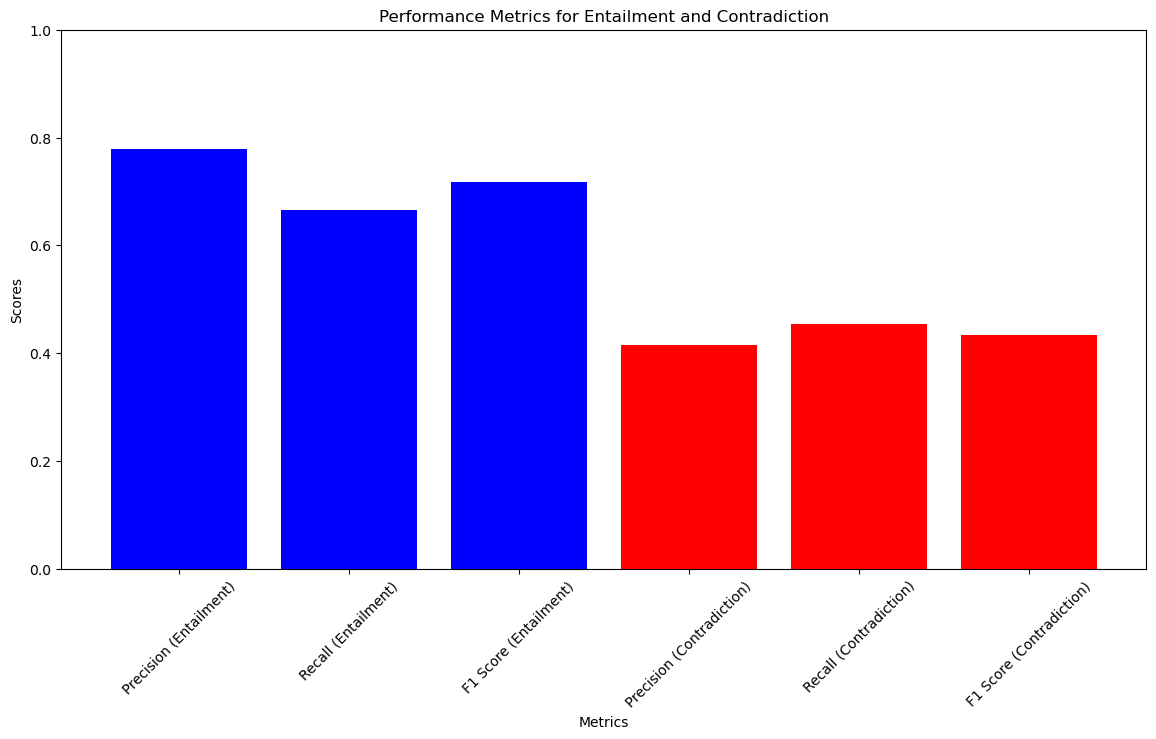

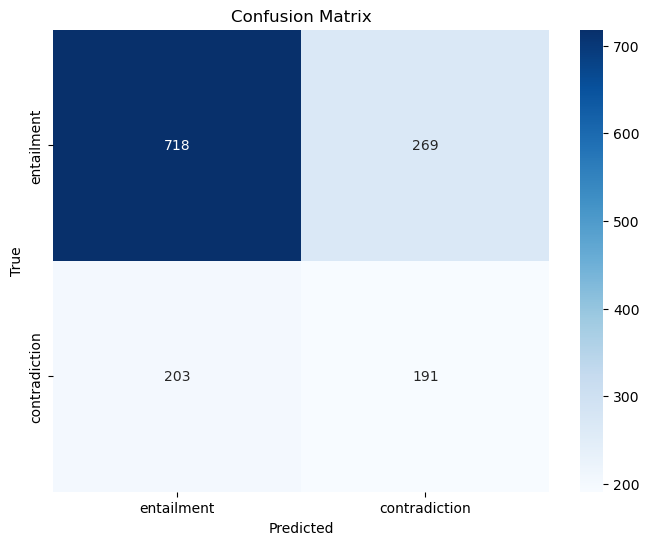

In [86]:
# Initialize the pipeline with unique book texts
bm_25_pipeline = EntailmentPipeline(unique_book_texts, "bart", 'bm25')

# Process claims through the pipeline
results = bm_25_pipeline.process_claims(claims, entailments)

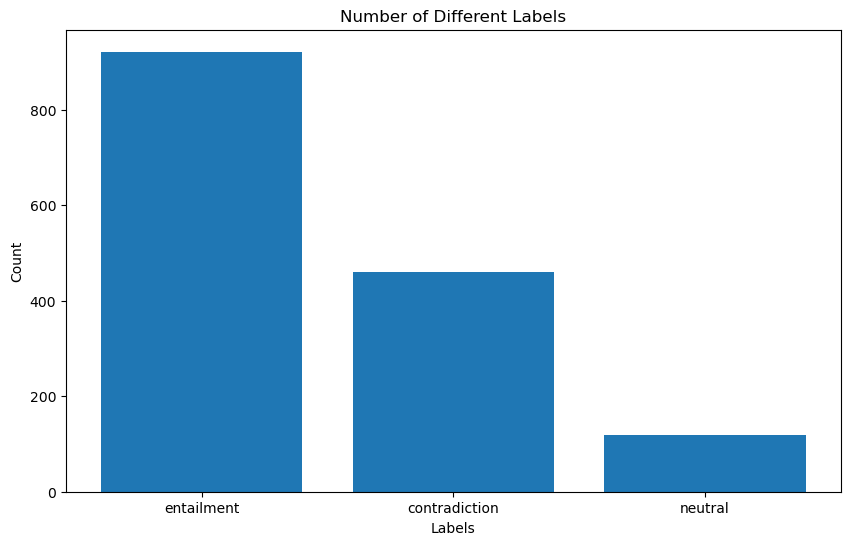

In [87]:
import matplotlib.pyplot as plt

# Count the number of different labels
label_counts = {}
for res in results:
    if res['labels'] is not None:
        label = res['labels']
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Different Labels')
plt.show()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

1024


Processing Claims: 100%|██████████| 1500/1500 [06:35<00:00,  3.79it/s]

['entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'entailment', 'entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'entai

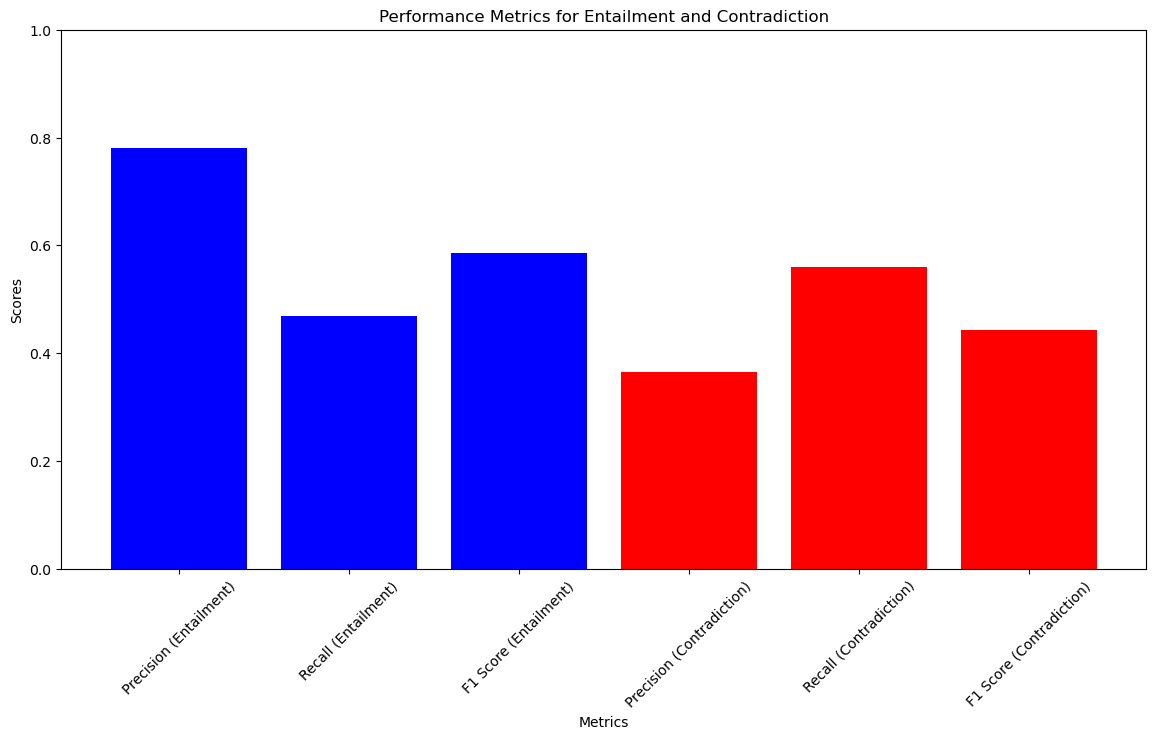

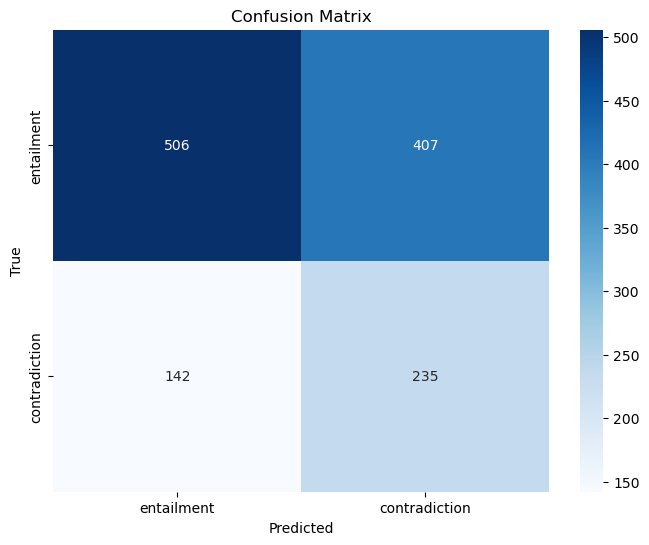

In [88]:
# Initialize the pipeline with unique book texts
dpr_pipeline = EntailmentPipeline(unique_book_texts, "bart", 'dpr')

# Process claims through the pipeline
results = dpr_pipeline.process_claims(claims, entailments)

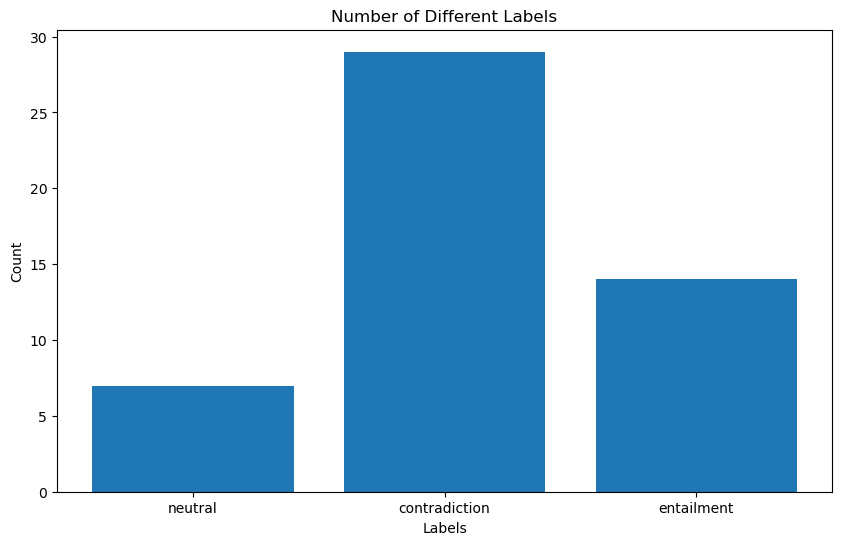

In [73]:
# Count the number of different labels
label_counts = {}
for res in results:
    if res['labels'] is not None:
        label = res['labels']
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Different Labels')
plt.show()

In [ ]:
# Initialize the pipeline with unique book texts
pipeline = EntailmentPipeline(unique_book_texts, "bert")
results = pipeline.process_claims(claims, entailments)